In [1]:
import sys
sys.path.append("../src")

In [20]:
import torch
from datasets import Dataset
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    TrainingArguments,
    Trainer,
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from labels import LABELS, label2id, id2label
import pandas as pd

In [3]:
import torch
torch.__version__

'2.5.1'

In [4]:
df = pd.read_csv('../data/processed/fineprint_clauses_train_ready.csv')
df.head()

,clause,label,source_policy,label_id
0,Communicate with you We use information we col...,none,youtube_privacy,0
1,"To have any such information deleted, submit t...",none,hulu_privacy,0
2,Because many of our services won’t function wi...,tracking,paypal_privacy,2
3,"For example, Uber uses identity verification t...",none,uber_driversdelivery_privacy,0
4,Car fleet information including capacities is ...,none,priceline_TOS,0


Splits 80 20

stratify=df["label_id] ensures each label remains equally represented

Without stratification, your smaller classes (e.g., arbitration, auto-renewal) might disappear from test set → invalid evaluation.

In [5]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label_id"],
    random_state=42,
)

len(train_df), len(test_df)

(10596, 2650)

## Creating huggingFace dataset
converts dataframe into a dataset object 
- works with map
- handles batching automatically
- works natively with trainer

Trainer expects a dataset, not a dataframe

In [6]:
# keeping only clause + label_id
train_dataset = Dataset.from_pandas(train_df[["clause", "label_id"]])
test_dataset = Dataset.from_pandas(test_df[["clause", "label_id"]])

## Tokenizer

loads the tokenizer that turns raw text into token IDS
the fast tokenizer:
- lowercase text (uncased model)
- splits into workpieces
- handles padding & truncation later

tokenizers define how text is represented for the model input

In [7]:
# load tokenizer and model

model_name = "distilbert-base-uncased"

tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)


/Users/amulya/Desktop/2025/Coding/FinePrint/FinePrint/Version2/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Creates a function that tokenizes clauses
- truncates long paragraphs
- pads shorter ones
- outputs input_ids, attention_mask[what is important and what is padded 1, 0]
256 becasue most clauses are 1 sentences so avoids truncation problems

In [8]:
# tokenizer function
def tokenize_batch(batch):
    return tokenizer(
        batch["clause"],
        truncation=True,
        padding="max_length",
        max_length=256,
    )


In [9]:
train_dataset = train_dataset.map(tokenize_batch, batched=True)
test_dataset  = test_dataset.map(tokenize_batch, batched=True)

Map: 100%|██████████| 2650/2650 [00:00<00:00, 25377.83 examples/s]


## Rename label column
renaming because trainer expects labels

In [11]:
# rename only if label_id exists
if "label_id" in train_dataset.column_names:
    train_dataset = train_dataset.rename_column("label_id", "labels")

if "label_id" in test_dataset.column_names:
    test_dataset = test_dataset.rename_column("label_id", "labels")


removes hidden __index_level_0__ columns that pandas - datasets sometimes adds
these extra columns break batching

In [12]:
# remove hf auto columns
# ensures trainer only sees correct columns

def drop_index_cols(ds):
    idx_cols = [c for c in ds.column_names if c.startswith("__")]
    return ds.remove_columns(idx_cols) if idx_cols else ds

train_dataset = drop_index_cols(train_dataset)
test_dataset  = drop_index_cols(test_dataset)

## Set torch format
converts all dataset columns to Pytorch tensors.
trainer internally expects pytorch tensors, not numpy arrays

In [13]:
train_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"],
)

test_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"],
)

load the pretrained DistilBERT model with classification head

9 output classes - risk categories


this makes my model

- trainable - finetuned on privacy clauses
- interpretable - trainer logs class names during eval

In [14]:
# load the model 

num_labels = len(LABELS)

model = DistilBertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Metrics function
Version agnostic, works everywhere

why weighted?
data set is imbalanced

weighted mtrics avoid arbitrarily high accuracy due to frequent "none" labels.

In [15]:
# metrics function

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="weighted", zero_division=0
    )

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

## Use the TrainingArguments API
Switching to version agnostic trainingArguements block that works on all transformers versions
as my install wasnt supporting evaluation_strategy

what this cell does?

- Defines 
    - where to save models and logs
    - learning rate
    - batch sizes
    - number of epochs
    - how often to log/save/evaluate

    

Create the HF training loop,

- Trainer handles
    - batching
    - GD
    - Eval loop
    - checkpointing
    - metrics
    - logging
    

In [16]:
training_args = TrainingArguments(
    output_dir="../models/fineprint-distilbert",
    
    do_train=True,
    do_eval=True,

    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,

    logging_steps=50,
    eval_steps=500,
    save_steps=500,
)

This version cannot do “epoch-based evaluation” because your installed TrainingArguments does not support it — but evaluation still happens every 500 steps, so training works fine.

In [17]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [18]:
trainer.train()

  3%|▎         | 50/1989 [00:29<14:51,  2.18it/s] 

{'loss': 0.8636, 'grad_norm': 1.2810713052749634, 'learning_rate': 1.949723479135244e-05, 'epoch': 0.08}


  5%|▌         | 100/1989 [00:52<14:42,  2.14it/s]

{'loss': 0.5246, 'grad_norm': 2.3895931243896484, 'learning_rate': 1.899446958270488e-05, 'epoch': 0.15}


  8%|▊         | 150/1989 [01:16<14:31,  2.11it/s]

{'loss': 0.3662, 'grad_norm': 1.6185007095336914, 'learning_rate': 1.8491704374057317e-05, 'epoch': 0.23}


 10%|█         | 200/1989 [01:39<14:11,  2.10it/s]

{'loss': 0.2211, 'grad_norm': 1.6394840478897095, 'learning_rate': 1.7988939165409756e-05, 'epoch': 0.3}


 13%|█▎        | 250/1989 [02:02<13:59,  2.07it/s]

{'loss': 0.2128, 'grad_norm': 0.32236447930336, 'learning_rate': 1.7486173956762194e-05, 'epoch': 0.38}


 15%|█▌        | 300/1989 [02:25<12:40,  2.22it/s]

{'loss': 0.1882, 'grad_norm': 0.3333265483379364, 'learning_rate': 1.6983408748114633e-05, 'epoch': 0.45}


 18%|█▊        | 350/1989 [02:48<12:21,  2.21it/s]

{'loss': 0.1616, 'grad_norm': 6.188037872314453, 'learning_rate': 1.6480643539467068e-05, 'epoch': 0.53}


 20%|██        | 400/1989 [03:11<11:58,  2.21it/s]

{'loss': 0.1548, 'grad_norm': 0.32440465688705444, 'learning_rate': 1.597787833081951e-05, 'epoch': 0.6}


 23%|██▎       | 450/1989 [03:34<11:36,  2.21it/s]

{'loss': 0.1068, 'grad_norm': 4.364646911621094, 'learning_rate': 1.547511312217195e-05, 'epoch': 0.68}


 25%|██▌       | 500/1989 [03:57<11:30,  2.16it/s]

{'loss': 0.0769, 'grad_norm': 2.6612744331359863, 'learning_rate': 1.4972347913524386e-05, 'epoch': 0.75}


 28%|██▊       | 550/1989 [04:21<10:52,  2.21it/s]

{'loss': 0.08, 'grad_norm': 0.40524858236312866, 'learning_rate': 1.4469582704876823e-05, 'epoch': 0.83}


 30%|███       | 600/1989 [04:44<10:40,  2.17it/s]

{'loss': 0.0622, 'grad_norm': 0.07268013805150986, 'learning_rate': 1.3966817496229261e-05, 'epoch': 0.9}


 33%|███▎      | 650/1989 [05:07<10:19,  2.16it/s]

{'loss': 0.0307, 'grad_norm': 4.018046855926514, 'learning_rate': 1.3464052287581701e-05, 'epoch': 0.98}


 35%|███▌      | 700/1989 [05:30<09:43,  2.21it/s]

{'loss': 0.0241, 'grad_norm': 0.05907268077135086, 'learning_rate': 1.296128707893414e-05, 'epoch': 1.06}


 38%|███▊      | 750/1989 [05:53<09:12,  2.24it/s]

{'loss': 0.0292, 'grad_norm': 0.04579269140958786, 'learning_rate': 1.2458521870286577e-05, 'epoch': 1.13}


 40%|████      | 800/1989 [06:16<08:56,  2.22it/s]

{'loss': 0.0602, 'grad_norm': 6.6636962890625, 'learning_rate': 1.1955756661639015e-05, 'epoch': 1.21}


 43%|████▎     | 850/1989 [06:39<08:40,  2.19it/s]

{'loss': 0.0296, 'grad_norm': 0.03280728682875633, 'learning_rate': 1.1452991452991454e-05, 'epoch': 1.28}


 45%|████▌     | 900/1989 [07:01<08:14,  2.20it/s]

{'loss': 0.0254, 'grad_norm': 0.03531728684902191, 'learning_rate': 1.0950226244343893e-05, 'epoch': 1.36}


 48%|████▊     | 950/1989 [07:23<07:44,  2.24it/s]

{'loss': 0.0418, 'grad_norm': 0.04772770032286644, 'learning_rate': 1.0447461035696331e-05, 'epoch': 1.43}


 50%|█████     | 1000/1989 [07:46<07:22,  2.23it/s]

{'loss': 0.0208, 'grad_norm': 0.35781049728393555, 'learning_rate': 9.94469582704877e-06, 'epoch': 1.51}


 53%|█████▎    | 1050/1989 [08:10<07:00,  2.23it/s]

{'loss': 0.0453, 'grad_norm': 0.02948687970638275, 'learning_rate': 9.441930618401207e-06, 'epoch': 1.58}


 55%|█████▌    | 1100/1989 [08:32<06:35,  2.25it/s]

{'loss': 0.0218, 'grad_norm': 0.2347133457660675, 'learning_rate': 8.939165409753647e-06, 'epoch': 1.66}


 58%|█████▊    | 1150/1989 [08:54<06:16,  2.23it/s]

{'loss': 0.0086, 'grad_norm': 0.023494550958275795, 'learning_rate': 8.436400201106084e-06, 'epoch': 1.73}


 60%|██████    | 1200/1989 [09:18<07:11,  1.83it/s]

{'loss': 0.0527, 'grad_norm': 0.025221114978194237, 'learning_rate': 7.933634992458522e-06, 'epoch': 1.81}


 63%|██████▎   | 1250/1989 [09:42<05:36,  2.20it/s]

{'loss': 0.0486, 'grad_norm': 0.04925193637609482, 'learning_rate': 7.430869783810961e-06, 'epoch': 1.89}


 65%|██████▌   | 1300/1989 [10:05<05:18,  2.16it/s]

{'loss': 0.026, 'grad_norm': 0.2647567093372345, 'learning_rate': 6.928104575163399e-06, 'epoch': 1.96}


 68%|██████▊   | 1350/1989 [10:27<04:49,  2.21it/s]

{'loss': 0.0457, 'grad_norm': 0.3327365219593048, 'learning_rate': 6.425339366515838e-06, 'epoch': 2.04}


 70%|███████   | 1400/1989 [10:50<04:26,  2.21it/s]

{'loss': 0.0083, 'grad_norm': 0.053556133061647415, 'learning_rate': 5.922574157868276e-06, 'epoch': 2.11}


 73%|███████▎  | 1450/1989 [11:13<04:05,  2.20it/s]

{'loss': 0.0342, 'grad_norm': 0.020908545702695847, 'learning_rate': 5.419808949220714e-06, 'epoch': 2.19}


 75%|███████▌  | 1500/1989 [11:36<03:43,  2.19it/s]

{'loss': 0.013, 'grad_norm': 0.14542847871780396, 'learning_rate': 4.917043740573153e-06, 'epoch': 2.26}


 78%|███████▊  | 1550/1989 [11:59<03:17,  2.22it/s]

{'loss': 0.0196, 'grad_norm': 0.017022056505084038, 'learning_rate': 4.4142785319255906e-06, 'epoch': 2.34}


 80%|████████  | 1600/1989 [12:23<03:03,  2.12it/s]

{'loss': 0.021, 'grad_norm': 0.01691598817706108, 'learning_rate': 3.911513323278029e-06, 'epoch': 2.41}


 83%|████████▎ | 1650/1989 [12:45<02:33,  2.21it/s]

{'loss': 0.0121, 'grad_norm': 0.15440864861011505, 'learning_rate': 3.408748114630468e-06, 'epoch': 2.49}


 85%|████████▌ | 1700/1989 [13:08<02:11,  2.19it/s]

{'loss': 0.0101, 'grad_norm': 0.019989512860774994, 'learning_rate': 2.9059829059829063e-06, 'epoch': 2.56}


 88%|████████▊ | 1750/1989 [13:31<01:48,  2.21it/s]

{'loss': 0.0087, 'grad_norm': 0.016611242666840553, 'learning_rate': 2.403217697335345e-06, 'epoch': 2.64}


 90%|█████████ | 1800/1989 [13:54<01:26,  2.18it/s]

{'loss': 0.0123, 'grad_norm': 0.039653170853853226, 'learning_rate': 1.9004524886877828e-06, 'epoch': 2.71}


 93%|█████████▎| 1850/1989 [14:17<01:03,  2.21it/s]

{'loss': 0.0037, 'grad_norm': 0.07936279475688934, 'learning_rate': 1.3976872800402214e-06, 'epoch': 2.79}


 96%|█████████▌| 1900/1989 [14:39<00:39,  2.25it/s]

{'loss': 0.0177, 'grad_norm': 0.01663121208548546, 'learning_rate': 8.949220713926597e-07, 'epoch': 2.87}


 98%|█████████▊| 1950/1989 [15:02<00:17,  2.17it/s]

{'loss': 0.0034, 'grad_norm': 0.01857461780309677, 'learning_rate': 3.921568627450981e-07, 'epoch': 2.94}


100%|██████████| 1989/1989 [15:20<00:00,  2.16it/s]

{'train_runtime': 920.0327, 'train_samples_per_second': 34.551, 'train_steps_per_second': 2.162, 'train_loss': 0.09289003205904714, 'epoch': 3.0}


TrainOutput(global_step=1989, training_loss=0.09289003205904714, metrics={'train_runtime': 920.0327, 'train_samples_per_second': 34.551, 'train_steps_per_second': 2.162, 'total_flos': 2105624571623424.0, 'train_loss': 0.09289003205904714, 'epoch': 3.0})

# Eval

Labels what model understands

which labels require more data

which labels require resampling or weighting

In [21]:
preds = trainer.predict(test_dataset)
y_true = preds.label_ids
y_pred = preds.predictions.argmax(axis=-1)

print(classification_report(
    y_true, y_pred,
    target_names=[id2label[i] for i in range(len(LABELS))],
    digits=3
))

100%|██████████| 166/166 [00:23<00:00,  7.09it/s]

              precision    recall  f1-score   support

        none      0.999     0.997     0.998      2326
data_sharing      0.981     0.994     0.987       154
    tracking      0.981     0.990     0.986       105
     refunds      0.963     0.963     0.963        27
    location      1.000     1.000     1.000        16
 arbitration      0.923     1.000     0.960        12
ai_decisions      1.000     1.000     1.000        10

    accuracy                          0.996      2650
   macro avg      0.978     0.992     0.985      2650
weighted avg      0.996     0.996     0.996      2650



# CF

In [22]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[2319,    3,    2,    1,    0,    1,    0],
       [   1,  153,    0,    0,    0,    0,    0],
       [   1,    0,  104,    0,    0,    0,    0],
       [   1,    0,    0,   26,    0,    0,    0],
       [   0,    0,    0,    0,   16,    0,    0],
       [   0,    0,    0,    0,    0,   12,    0],
       [   0,    0,    0,    0,    0,    0,   10]])

# Save Model

In [23]:
save_dir = "../models/fineprint-distilbert-best"
trainer.save_model(save_dir)
tokenizer.save_pretrained(save_dir)

('../models/fineprint-distilbert-best/tokenizer_config.json',
 '../models/fineprint-distilbert-best/special_tokens_map.json',
 '../models/fineprint-distilbert-best/vocab.txt',
 '../models/fineprint-distilbert-best/added_tokens.json',
 '../models/fineprint-distilbert-best/tokenizer.json')

# Error Analysis

## Compute Predictions

In [27]:
preds = trainer.predict(test_dataset)
y_true = preds.label_ids
y_pred = preds.predictions.argmax(axis=-1)

100%|██████████| 166/166 [00:23<00:00,  6.99it/s]


## Build error analysis DF
every clause + true label + predicted label

In [28]:
import pandas as pd

errors = pd.DataFrame({
    "clause": test_df["clause"].values,
    "true_label": [id2label[l] for l in y_true],
    "pred_label": [id2label[p] for p in y_pred],
})

errors["correct"] = errors["true_label"] == errors["pred_label"]

errors.head()

,clause,true_label,pred_label,correct
0,When we no longer require the personal informa...,none,none,True
1,We share or disclose your information with you...,data_sharing,data_sharing,True
2,Qualification Criteria: Offers are only valid ...,none,none,True
3,To learn more about how we share information w...,data_sharing,data_sharing,True
4,By accessing the transaction details page in y...,none,none,True


## Showing only the misclassified samples

In [29]:
mistakes = errors[errors["correct"] == False]
mistakes.head(20)

,clause,true_label,pred_label,correct
248,Flexible Cancellation Rates Priceline offers c...,none,refunds,False
374,If you use a Netflix app (such as the main Net...,none,tracking,False
595,How we share your personal information We may ...,none,data_sharing,False
732,Sharing Information You should know the ways w...,none,data_sharing,False
969,See JetBlue travel credit info Canceling withi...,refunds,none,False
1077,"Some use device identifiers, or other identifi...",tracking,none,False
1562,"If you choose not to allow this, you may still...",none,tracking,False
1603,Uber is required under applicable law to share...,none,data_sharing,False
1984,"Third parties, including service providers, Pa...",data_sharing,none,False
2363,"BY AGREEING TO ARBITRATION, THE PARTIES AGREE ...",none,arbitration,False


In [30]:
mistakes["true_label"].value_counts()

true_label
none            7
refunds         1
tracking        1
data_sharing    1
Name: count, dtype: int64

In [31]:
mistakes["pred_label"].value_counts()

pred_label
data_sharing    3
none            3
tracking        2
refunds         1
arbitration     1
Name: count, dtype: int64

## CM

In [32]:
import numpy as np

unique_labels = [id2label[i] for i in range(len(LABELS))]

cm = confusion_matrix(y_true, y_pred)

cm_df = pd.DataFrame(cm, index=unique_labels, columns=unique_labels)
cm_df

,none,data_sharing,tracking,refunds,location,arbitration,ai_decisions
none,2319,3,2,1,0,1,0
data_sharing,1,153,0,0,0,0,0
tracking,1,0,104,0,0,0,0
refunds,1,0,0,26,0,0,0
location,0,0,0,0,16,0,0
arbitration,0,0,0,0,0,12,0
ai_decisions,0,0,0,0,0,0,10


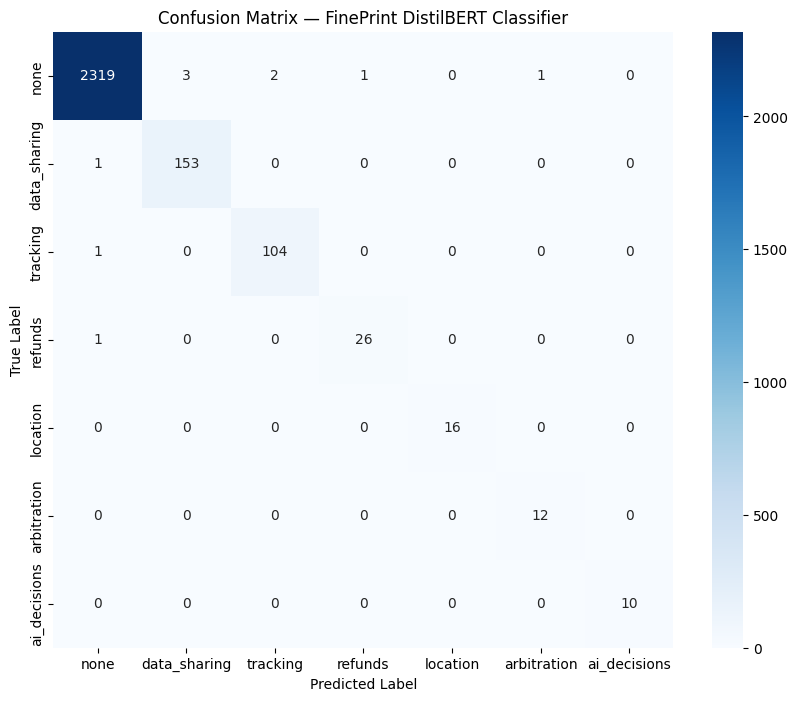

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix — FinePrint DistilBERT Classifier")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

## Check if train/test split leaked rows

In [24]:
len(train_df.merge(test_df, how="inner"))

1261

This is a major problem. This is data leakage. 1261 clauses appear both in training and testing set, thats why the accuracy is so high.

In [25]:
df["clause"].duplicated().sum()

np.int64(1704)

In [26]:
long_clauses = df[df["clause"].str.len() > 1000]
len(long_clauses)

0

# Debugging

Transformers 4.40.2

Accelerate 0.30.1

In [36]:
import transformers, accelerate
transformers.__version__, accelerate.__version__

('4.57.3', '0.31.0')